# Data 90:10

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import cv2
from google.colab import drive
import random


In [ ]:
# Mount Google Drive (uncomment jika diperlukan untuk Google Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Configuration variables
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.00001

In [ ]:
# Tetapkan seed global
def set_seed(seed_value):
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

# Tetapkan seed
set_seed(42)

In [ ]:
# Konfigurasi path data
DATA_DIR = '/content/drive/MyDrive/TA'  # direktori utama dataset
KARIES_DIR = os.path.join(DATA_DIR, 'database2/karies')  # direktori gambar karies
SEHAT_DIR = os.path.join(DATA_DIR, 'database2/sehat')   # direktori gambar sehat
PROCESSED_DIR = os.path.join(DATA_DIR, 'dt2/individual')  # direktori hasil preprocessing

In [ ]:
# ===== AWAL PEMERIKSAAN DATA =====
# Memeriksa jumlah gambar di setiap folder
jumlah_karies = len(os.listdir(KARIES_DIR))
jumlah_sehat = len(os.listdir(SEHAT_DIR))

print(f"Jumlah gambar karies: {jumlah_karies}")
print(f"Jumlah gambar sehat: {jumlah_sehat}")

Jumlah gambar karies: 244
Jumlah gambar sehat: 381


#Preprocessing Gambar

In [ ]:
def preprocess_image(img_path, output_path=None, denoise=True, clahe=True, save=False):
    """
    Fungsi untuk preprocessing gambar panoramik gigi

    Parameters:
    - img_path: Path ke gambar input
    - output_path: Path untuk menyimpan gambar hasil preprocessing (opsional)
    - denoise: Apakah menerapkan denoising
    - clahe: Apakah menerapkan Contrast Limited Adaptive Histogram Equalization
    - save: Apakah menyimpan hasil preprocessing

    Returns:
    - img_processed: Gambar yang telah diproses
    """
    # Baca gambar
    img = cv2.imread(img_path)

    if img is None:
        print(f"Error: Tidak dapat membaca gambar dari {img_path}")
        return None

    # Konversi ke grayscale jika gambar berwarna
    if len(img.shape) == 3:
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        img_gray = img

    # Menerapkan denoising untuk mengurangi noise
    if denoise:
        img_gray = cv2.fastNlMeansDenoising(img_gray, None, 10, 7, 21)

    # Menerapkan CLAHE untuk meningkatkan kontras
    if clahe:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img_processed = clahe.apply(img_gray)
    else:
        img_processed = img_gray

    # Menyimpan hasil preprocessing jika diperlukan
    if save and output_path:
        cv2.imwrite(output_path, img_processed)

    return img_processed

In [ ]:
# Fungsi untuk preprocessing batch gambar (dapat dijalankan secara opsional)
def batch_preprocess(input_dir, output_dir):
    """
    Memproses semua gambar dalam direktori dan menyimpan hasil
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    files = os.listdir(input_dir)
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            input_path = os.path.join(input_dir, file)
            output_path = os.path.join(output_dir, file)
            preprocess_image(input_path, output_path, save=True)
            print(f"Preprocessed: {file}")


In [ ]:
# CATATAN: Uncomment baris di bawah jika ingin melakukan preprocessing manual
batch_preprocess(KARIES_DIR, os.path.join(PROCESSED_DIR, 'processed_karies'))
batch_preprocess(SEHAT_DIR, os.path.join(PROCESSED_DIR, 'processed_sehat'))

Preprocessed: 20250507_145913.jpg
Preprocessed: 161.jpg
Preprocessed: 436.jpg
Preprocessed: 354.jpg
Preprocessed: 182.jpg
Preprocessed: 278.jpg
Preprocessed: 408.jpg
Preprocessed: 13.jpg
Preprocessed: 476.jpg
Preprocessed: 515.jpg
Preprocessed: 579.jpg
Preprocessed: 522.jpg
Preprocessed: 173.jpg
Preprocessed: 384.jpg
Preprocessed: 434.jpg
Preprocessed: 297.jpg
Preprocessed: 43.jpg
Preprocessed: 115.jpg
Preprocessed: 584.jpg
Preprocessed: 6.jpg
Preprocessed: 20250507_153128.jpg
Preprocessed: 551.jpg
Preprocessed: 572.jpg
Preprocessed: 375.jpg
Preprocessed: 192.jpg
Preprocessed: 20250507_153334.jpg
Preprocessed: 335.jpg
Preprocessed: 273.jpg
Preprocessed: 327.jpg
Preprocessed: 191.jpg
Preprocessed: 556.jpg
Preprocessed: 489.jpg
Preprocessed: 292.jpg
Preprocessed: 235.jpg
Preprocessed: 225.jpg
Preprocessed: 308.jpg
Preprocessed: 211.jpg
Preprocessed: 402.jpg
Preprocessed: 20250507_154131.jpg
Preprocessed: 20250507_154117.jpg
Preprocessed: 506.jpg
Preprocessed: 323.jpg
Preprocessed: 202505

#Preprocessing Data

In [ ]:
# ===== BAGIAN PRE-PROCESSING DATA =====
# Membuat generator data dengan augmentasi untuk data training
# Preprocessing meliputi:
# 1. Rescaling - Normalisasi nilai piksel dari 0-255 menjadi 0-1
# 2. Augmentasi data - Meningkatkan variasi data training
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisasi nilai piksel
    validation_split=0.1,  # 10% data untuk validasi
    rotation_range=20,  # Rotasi gambar hingga 20 derajat
    width_shift_range=0.2,  # Pergeseran horizontal
    height_shift_range=0.2,  # Pergeseran vertikal
    shear_range=0.2,  # Transformasi shear
    zoom_range=0.2,  # Zoom in/out
    horizontal_flip=True,  # Refleksi horizontal
    fill_mode='nearest',  # Strategi mengisi piksel baru
    # brightness_range=[0.8, 1.2]  # Variasi kecerahan (opsional untuk menangani kontras berbeda)
)


In [ ]:
# Generator untuk data validasi (hanya rescaling)
validation_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisasi nilai piksel
    validation_split=0.1  # 20% data untuk validasi
)

In [ ]:
# Memuat data dan menerapkan preprocessing
# target_size - Mengubah ukuran semua gambar menjadi 224x224 piksel (preprocessing ukuran)
train_generator = train_datagen.flow_from_directory(
    PROCESSED_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),  # Resize gambar ke ukuran standar
    batch_size=BATCH_SIZE,
    class_mode='binary',  # Klasifikasi biner: karies atau sehat
    subset='training',
    shuffle=True,  # Mengacak data untuk training
    seed=42
)

# Memuat data validasi
validation_generator = validation_datagen.flow_from_directory(
    PROCESSED_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),  # Resize gambar ke ukuran standar
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False,  # Tidak mengacak data validasi
    seed=42
)


Found 563 images belonging to 2 classes.
Found 62 images belonging to 2 classes.


# Building Model

In [ ]:
# Membangun model CNN
model = models.Sequential([
    # Layer konvolusi pertama
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Layer konvolusi kedua
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Layer konvolusi ketiga
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Layer konvolusi keempat
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Layer flatten untuk mengubah menjadi format 1D
    layers.Flatten(),

    # Fully connected layers
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  # Dropout untuk mengurangi overfitting
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),

    # Layer output
    layers.Dense(1, activation='sigmoid')  # sigmoid untuk klasifikasi biner
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Kompilasi model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
tf.keras.utils.set_random_seed(42)

In [ ]:
# Ringkasan model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,212,545 (99.99 MB)

 Trainable params: 26,211,585 (99.99 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# Callbacks untuk training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)

In [ ]:
# Menyimpan model terbaik
checkpoint_filepath = '/content/drive/MyDrive/TA/database2/hasilta6/model_karies_gigi.h5'
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

In [ ]:
# Melatih model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5024 - loss: 0.9648
Epoch 1: val_accuracy improved from -inf to 0.61290, saving model to /content/drive/MyDrive/TA/database2/hasilta6/model_karies_gigi.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 147s 8s/step - accuracy: 0.5052 - loss: 0.9616 - val_accuracy: 0.6129 - val_loss: 0.6918
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6108 - loss: 0.7692
Epoch 2: val_accuracy did not improve from 0.61290
18/18 ━━━━━━━━━━━━━━━━━━━━ 125s 7s/step - accuracy: 0.6109 - loss: 0.7681 - val_accuracy: 0.6129 - val_loss: 0.6853
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6531 - loss: 0.7091
Epoch 3: val_accuracy did not improve from 0.61290
18/18 ━━━━━━━━━━━━━━━━━━━━ 124s 7s/step - accuracy: 0.6529 - loss: 0.7105 - val_accuracy: 0.6129 - val_loss: 0.6807
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6972 - loss: 0.6530
Epoch 4: val_accuracy did not improve from 0.61290
18/18 ━━━━━━━━━━━━━━━━━━━━ 116s 6s/step - accuracy: 0.6956 - loss: 0.6550 - val_accuracy: 0.6129 - val_loss: 0.6711
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6196 - loss: 0.7535
Epoch 5: val_accuracy did not improve from 0.61290


18/18 ━━━━━━━━━━━━━━━━━━━━ 122s 7s/step - accuracy: 0.7140 - loss: 0.5600 - val_accuracy: 0.6290 - val_loss: 0.7617
Epoch 28/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6860 - loss: 0.6265
Epoch 28: val_accuracy did not improve from 0.62903
18/18 ━━━━━━━━━━━━━━━━━━━━ 137s 6s/step - accuracy: 0.6868 - loss: 0.6260 - val_accuracy: 0.6290 - val_loss: 0.7997
Epoch 29/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6683 - loss: 0.6270
Epoch 29: val_accuracy did not improve from 0.62903
18/18 ━━━━━━━━━━━━━━━━━━━━ 142s 6s/step - accuracy: 0.6695 - loss: 0.6253 - val_accuracy: 0.6290 - val_loss: 0.7947
Epoch 30/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7040 - loss: 0.5760
Epoch 30: val_accuracy did not improve from 0.62903
18/18 ━━━━━━━━━━━━━━━━━━━━ 138s 6s/step - accuracy: 0.7046 - loss: 0.5755 - val_accuracy: 0.6290 - val_loss: 0.7508
Epoch 31/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6864 - loss: 0.6064
Epoch 31: val_accuracy improved from 0.62903

18/18 ━━━━━━━━━━━━━━━━━━━━ 122s 7s/step - accuracy: 0.6871 - loss: 0.6057 - val_accuracy: 0.6452 - val_loss: 0.7241
Epoch 32/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7578 - loss: 0.4864
Epoch 32: val_accuracy did not improve from 0.64516
18/18 ━━━━━━━━━━━━━━━━━━━━ 133s 7s/step - accuracy: 0.7570 - loss: 0.4883 - val_accuracy: 0.6452 - val_loss: 0.6652
Epoch 33/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7505 - loss: 0.5125
Epoch 33: val_accuracy did not improve from 0.64516
18/18 ━━━━━━━━━━━━━━━━━━━━ 113s 6s/step - accuracy: 0.7499 - loss: 0.5130 - val_accuracy: 0.6452 - val_loss: 0.6120
Epoch 34/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7715 - loss: 0.4834
Epoch 34: val_accuracy improved from 0.64516 to 0.66129, saving model to /content/drive/MyDrive/TA/database2/hasilta6/model_karies_gigi.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 122s 7s/step - accuracy: 0.7703 - loss: 0.4850 - val_accuracy: 0.6613 - val_loss: 0.5981
Epoch 35/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7210 - loss: 0.5406
Epoch 35: val_accuracy did not improve from 0.66129
18/18 ━━━━━━━━━━━━━━━━━━━━ 124s 7s/step - accuracy: 0.7219 - loss: 0.5406 - val_accuracy: 0.6613 - val_loss: 0.5384
Epoch 36/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7196 - loss: 0.5311
Epoch 36: val_accuracy improved from 0.66129 to 0.69355, saving model to /content/drive/MyDrive/TA/database2/hasilta6/model_karies_gigi.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 121s 7s/step - accuracy: 0.7193 - loss: 0.5316 - val_accuracy: 0.6935 - val_loss: 0.5058
Epoch 37/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7270 - loss: 0.5170
Epoch 37: val_accuracy did not improve from 0.69355
18/18 ━━━━━━━━━━━━━━━━━━━━ 131s 7s/step - accuracy: 0.7269 - loss: 0.5174 - val_accuracy: 0.6774 - val_loss: 0.5177
Epoch 38/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7498 - loss: 0.5392
Epoch 38: val_accuracy did not improve from 0.69355
18/18 ━━━━━━━━━━━━━━━━━━━━ 124s 6s/step - accuracy: 0.7492 - loss: 0.5391 - val_accuracy: 0.6935 - val_loss: 0.4964
Epoch 39/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7538 - loss: 0.5856
Epoch 39: val_accuracy did not improve from 0.69355
18/18 ━━━━━━━━━━━━━━━━━━━━ 118s 7s/step - accuracy: 0.7527 - loss: 0.5849 - val_accuracy: 0.6935 - val_loss: 0.5495
Epoch 40/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7090 - loss: 0.5531
Epoch 40: val_accuracy improved from 0.69355

18/18 ━━━━━━━━━━━━━━━━━━━━ 121s 7s/step - accuracy: 0.7098 - loss: 0.5530 - val_accuracy: 0.7258 - val_loss: 0.5207
Epoch 41/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7387 - loss: 0.5345
Epoch 41: val_accuracy improved from 0.72581 to 0.79032, saving model to /content/drive/MyDrive/TA/database2/hasilta6/model_karies_gigi.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 127s 7s/step - accuracy: 0.7391 - loss: 0.5337 - val_accuracy: 0.7903 - val_loss: 0.5114
Epoch 42/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7073 - loss: 0.5727
Epoch 42: val_accuracy did not improve from 0.79032
18/18 ━━━━━━━━━━━━━━━━━━━━ 133s 7s/step - accuracy: 0.7081 - loss: 0.5721 - val_accuracy: 0.7742 - val_loss: 0.5337
Epoch 43/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7806 - loss: 0.5129
Epoch 43: val_accuracy did not improve from 0.79032
18/18 ━━━━━━━━━━━━━━━━━━━━ 113s 6s/step - accuracy: 0.7792 - loss: 0.5132 - val_accuracy: 0.7419 - val_loss: 0.5522
Epoch 44/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7791 - loss: 0.4951
Epoch 44: val_accuracy did not improve from 0.79032
18/18 ━━━━━━━━━━━━━━━━━━━━ 116s 6s/step - accuracy: 0.7783 - loss: 0.4958 - val_accuracy: 0.7097 - val_loss: 0.5561
Epoch 45/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7634 - loss: 0.5280
Epoch 45: val_accuracy did not improve from 

18/18 ━━━━━━━━━━━━━━━━━━━━ 121s 7s/step - accuracy: 0.7589 - loss: 0.5159 - val_accuracy: 0.8065 - val_loss: 0.4872
Epoch 50/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7709 - loss: 0.4721
Epoch 50: val_accuracy did not improve from 0.80645
18/18 ━━━━━━━━━━━━━━━━━━━━ 125s 7s/step - accuracy: 0.7697 - loss: 0.4745 - val_accuracy: 0.7903 - val_loss: 0.5097


#Evaluation

In [ ]:
# Menampilkan hasil terbaik dari training
best_val_acc_idx = np.argmax(history.history['val_accuracy'])
best_train_acc = history.history['accuracy'][best_val_acc_idx]
best_val_acc = history.history['val_accuracy'][best_val_acc_idx]
best_epoch = best_val_acc_idx + 1

print("\nHasil Terbaik dari Training:")
print(f"Epoch terbaik: {best_epoch}")
print(f"Akurasi training terbaik: {best_train_acc:.4f}")
print(f"Akurasi validasi terbaik: {best_val_acc:.4f}")


Hasil Terbaik dari Training:
Epoch terbaik: 49
Akurasi training terbaik: 0.7549
Akurasi validasi terbaik: 0.8065


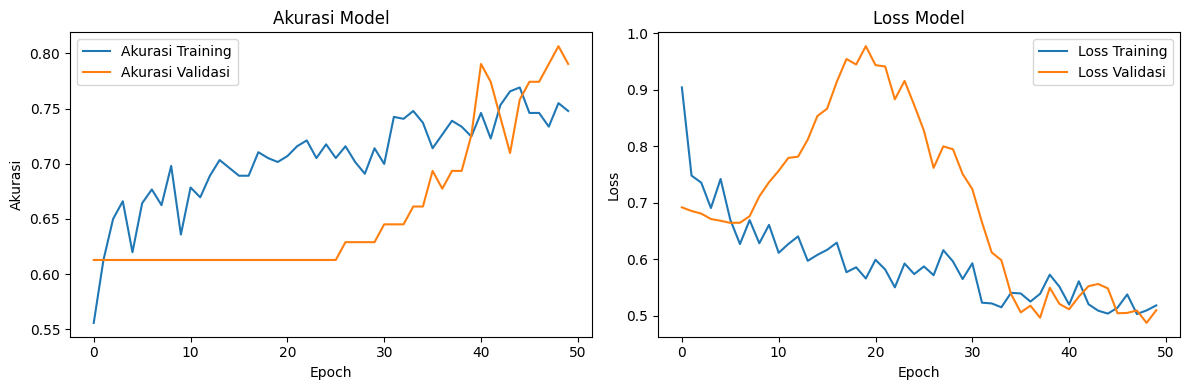

In [ ]:
# Visualisasi hasil training
plt.figure(figsize=(12, 4))

# Plot akurasi training dan validasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Akurasi Training')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

# Plot loss training dan validasi
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss Training')
plt.plot(history.history['val_loss'], label='Loss Validasi')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/TA/database2/hasilta6/training_history.png')
plt.show()

In [ ]:
# Evaluasi model pada data validasi
validation_generator.reset()
y_pred_probs = model.predict(validation_generator)
y_pred = (y_pred_probs > 0.5).astype(int)
y_true = validation_generator.classes

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


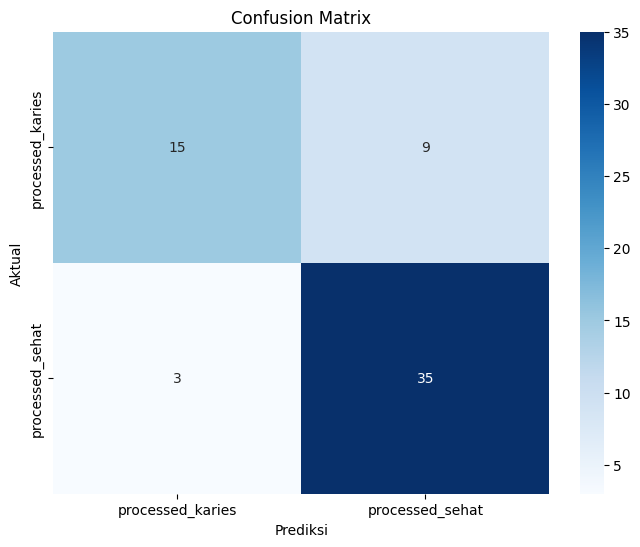

In [ ]:
# Hitung dan tampilkan confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(validation_generator.class_indices.keys()),
            yticklabels=list(validation_generator.class_indices.keys()))
plt.title('Confusion Matrix')
plt.ylabel('Aktual')
plt.xlabel('Prediksi')
plt.savefig('/content/drive/MyDrive/TA/database2/hasilta6/confusion_matrix.png')
plt.show()

In [ ]:
# Cetak laporan klasifikasi
print("\nLaporan Klasifikasi:")
print(classification_report(
    y_true,
    y_pred,
    target_names=list(validation_generator.class_indices.keys())
))


Laporan Klasifikasi:
                  precision    recall  f1-score   support

processed_karies       0.83      0.62      0.71        24
 processed_sehat       0.80      0.92      0.85        38

        accuracy                           0.81        62
       macro avg       0.81      0.77      0.78        62
    weighted avg       0.81      0.81      0.80        62



In [ ]:
# Menyimpan model final
model.save('/content/drive/MyDrive/TA/database2/hasilta6/model_karies_gigi_final.h5')